<h1 style="background-color:rgb(21, 131, 85); font-family: newtimeroman; font-size: 250%; color: white; border-radius: 80px 20px; padding: 25px; text-align: center;">
<b>labeled dataset collected from twitter (Hate Speech)</b>
</h1>


**Objective**

- classify tweets containing hate speech from other tweets : <br>
pos : No hate speech <br>
neg : Contains hate speech <br>

This is a sentiment classification problem. The dataset consists of Arabic text samples labeled as positive (pos) or negative (neg). The goal is to train a model to classify new text as either positive or negative sentiment based on these examples.

# `00` **Import used libraries**

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import eli5


# `01` **Load Dataset**

In [130]:
train_pos = pd.read_csv("data/train_Arabic_tweets_positive_20190413.tsv", sep='\t', header=None)
train_neg = pd.read_csv("data/train_Arabic_tweets_negative_20190413.tsv", sep='\t', header=None)
train_data = pd.concat([train_pos, train_neg], ignore_index=True)
train_data.columns = ['label', 'tweet']
del train_pos, train_neg

In [ ]:
def highlight_col(x, df):
    mask =  df['label'] == 'pos'
    mask2 = df['label'] == 'neg'
    x = pd.DataFrame('', index=df.index, columns=df.columns)
    x.loc[mask] = 'background-color: #58d98f'
    x.loc[mask2] = 'background-color: #ff5151'
    return x    

In [132]:
pd.set_option('display.max_colwidth', 100000)
df_tmp = train_data.sample(10)
df_tmp.style.apply(lambda x: highlight_col(x, df_tmp), axis=None)

,label,tweet
223,pos,[ 📊 ] مراكز اغنية Boy With Luv بالتعاون مع هالزي في المخططات الكورية الموسيقية الساعة :00 م بتوقيت كوريا :…
16239,pos,صباح الخير 💚
1749,pos,صبااح الخيير 😋
18156,pos,بمناسبة فوز الهلال .. 💙 سحب على آيفون XR📱 رتويت وتابع - السحب بعد ساعة موثق بالفديو 💪
43529,neg,صباح الخير 😴
19594,pos,#صباحات_الهلال #الهلال_الاهلي الله يجعله يوم جميل على الهلاليين 💙
26350,neg,ولا تميل قلوبنا ..!! ألا لمن يصعب علينا امتلاكه 💔
7768,pos,باتسر تقلبون عليه يالمشجعين الهلاليين المتعصبين 👌 انا حددت (المتعصبين) لا تش…
14676,pos,صباح الخير عموره، اتمنى انك بخير.. تفضل اغنية الصباح — صباح النور، ذوقك عظيم 💛
17082,pos,🎥 لا للتعصب الرياضي.. كلنا عيال سلمان.


In [133]:
test_pos = pd.read_csv("data/test_Arabic_tweets_positive_20190413.tsv", sep='\t', header=None)
test_neg = pd.read_csv("data/test_Arabic_tweets_negative_20190413.tsv", sep='\t', header=None)
test_data = pd.concat([test_pos, test_neg], ignore_index=True)
test_data.columns = ['label', 'tweet']
del test_pos, test_neg

In [134]:
df_tmp = test_data.sample(5)
df_tmp.style.apply(lambda x: highlight_col(x, df_tmp), axis=None)

,label,tweet
5508,pos,☀ إشراقة صباحية ☀ 📖📝 اعتدنا على النعم .. حتى إننا إذا سئلنا عن حالنا قلنا : لا جديد .. فهل استشعرنا تجدد العا…
10494,neg,أبغى بنت 💔
1771,pos,اللهم ، أنت لكل عظيمة ، ولكل نازلة ، فصل على محمد وآل محمد ، واكفني كل…
2181,pos,"فبدلا ان نربي الطفل ""اذا ما صليت بتدخل النار"" و الاخلاق تاتي من ""خوف فقط"".. ا…"
10440,neg,كل حد مخلص ميدات الا انا 💔


In [135]:
train_data.count()

label    45275
tweet    45275
dtype: int64

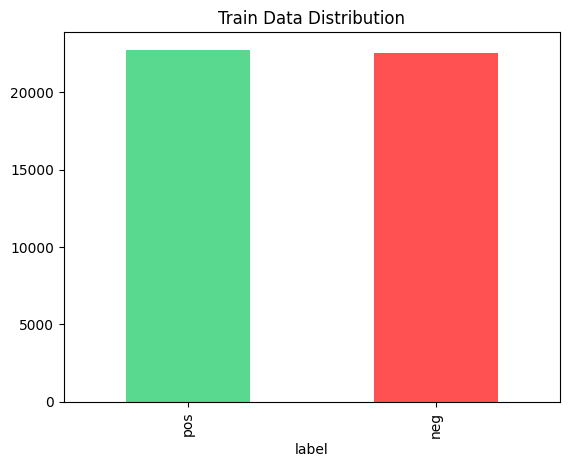

In [136]:
train_data['label'].value_counts().plot(kind='bar', title='Train Data Distribution',color=['#58d98f', '#ff5151']);

# `03` **Cleaning and Preprocessing**

In [137]:
def normalize_arabic(text):
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ى', 'ي', text)
    text = re.sub(r'ؤ', 'ء', text)
    text = re.sub(r'ئ', 'ء', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'ـ', '', text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                            ـ     # Tatwil/Kashida
                        """, re.VERBOSE)
    return re.sub(arabic_diacritics, '', text)

def clean_spaces(text):
    text = ' '.join(text.split())
    # remove space before/after emojis or symbols
    emoji_pattern = re.compile(r'\s*([😂😊💙🤔😭🙈💔])\s*')
    text = emoji_pattern.sub(r'\1', text)
    return text



In [ ]:
def preprocess(text):
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = clean_spaces(text)
    return text

In [ ]:
train_data['tweet'] = train_data['tweet'].apply(preprocess)
test_data['tweet'] = test_data['tweet'].apply(preprocess)

In [140]:
df_tmp = test_data.sample(5)
df_tmp.style.apply(lambda x: highlight_col(x, df_tmp),axis=None)

,label,tweet
5125,pos,تصبحون ع çaga💙
2918,pos,بمناسبه فوز الهلال ..💙سحب علي ايفون XR📱 رتويت وتابع - السحب بعد ساعه موثق بالفديو 💪
10135,neg,ليش ما تعرف ان من شهر صفر مافي شيء اسمه هيءه عماليه وان اختصاصها تحول من وزا…
9135,neg,"- اذا كان لديك كبرياء, يجعلك تتجاهلني فانا لدي عزه نفس تنسيني من انت💔"
7754,neg,حكاالهاا تتزوجيني !🙈😍🙈-اغمي عليها من الفرحه 😨😱 صحيت حكالها ولك بمزح معك 😕 -مااتت😂😂💃💃


# `04` **Modeling**

## **Try Tf-idf**

In [168]:
vec = TfidfVectorizer(analyzer='char_wb', ngram_range=(1,5),min_df=.01, max_df=.3)
clf = LogisticRegression()
pipe_tfidf = make_pipeline(vec, clf)
pipe_tfidf.fit(train_data.tweet, train_data.label)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char_wb', max_df=0.3, min_df=0.01,
                                 ngram_range=(1, 5))),
                ('logisticregression', LogisticRegression())])

In [169]:
def print_report(pipe, x_test, y_test):
    y_pred = pipe.predict(x_test)
    report = metrics.classification_report(y_test, y_pred)
    print(report)
    print("accuracy: {:0.4f}".format(metrics.accuracy_score(y_test, y_pred)))
    cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    disp.plot(cmap="magma")
    plt.show()

              precision    recall  f1-score   support

         neg       0.86      0.84      0.85      5768
         pos       0.84      0.86      0.85      5752

    accuracy                           0.85     11520
   macro avg       0.85      0.85      0.85     11520
weighted avg       0.85      0.85      0.85     11520

accuracy: 0.8480


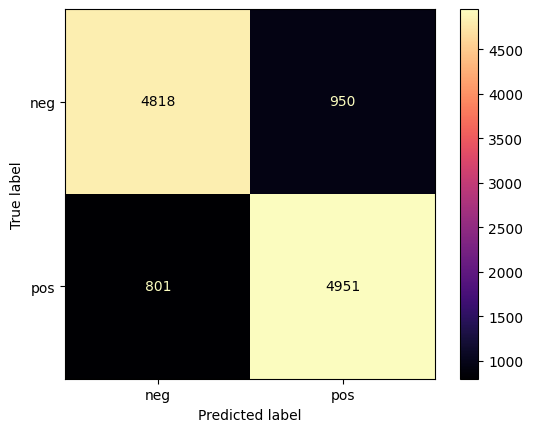

In [170]:
print_report(pipe_tfidf, test_data.tweet, test_data.label)

In [171]:
eli5.show_weights(clf, vec=vec, top=10)

In [174]:
for _, row in test_data.sample(5).iterrows():
    print(f"true label: {row['label']}")
    display(eli5.show_prediction(clf, row['tweet'], vec=vec,))


true label: pos


true label: neg


true label: neg


true label: neg


true label: neg


## **Try bag of words (BOW)**

In [164]:
vec = CountVectorizer(ngram_range=(1,5))
clf = LogisticRegression()

pipe = make_pipeline(vec, clf)
pipe.fit(train_data.tweet, train_data.label)

Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 5))),
                ('logisticregression', LogisticRegression())])

              precision    recall  f1-score   support

         neg       0.77      0.86      0.81      5768
         pos       0.84      0.75      0.79      5752

    accuracy                           0.80     11520
   macro avg       0.81      0.80      0.80     11520
weighted avg       0.81      0.80      0.80     11520

accuracy: 0.8038


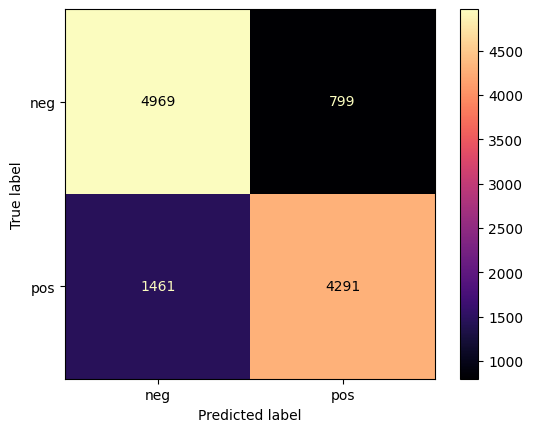

In [166]:
print_report(pipe, test_data.tweet, test_data.label)

## the most important features

In [167]:
eli5.show_weights(clf, vec=vec, top=20)

Weight?,Feature
+2.097,وصباحك
+1.969,صباحك
+1.709,يسعدك
+1.647,الطيب
+1.609,كيف اللوك
+1.544,مبروك
+1.538,حفله_ديانا_حداد_بالكويت
+1.521,blackpinkxcoachella_d1
+1.504,وياك
+1.478,موفقين


## Try our model on some tweets

In [162]:
for i , row in test_data.sample(5).iterrows():
    print(f"true label: {row['label']}")
    display(eli5.show_prediction(clf, row['tweet'], vec=vec,))

true label: neg


true label: pos


true label: neg


true label: neg


true label: neg
